True
[1]
tensor(0.0043, dtype=torch.float64)


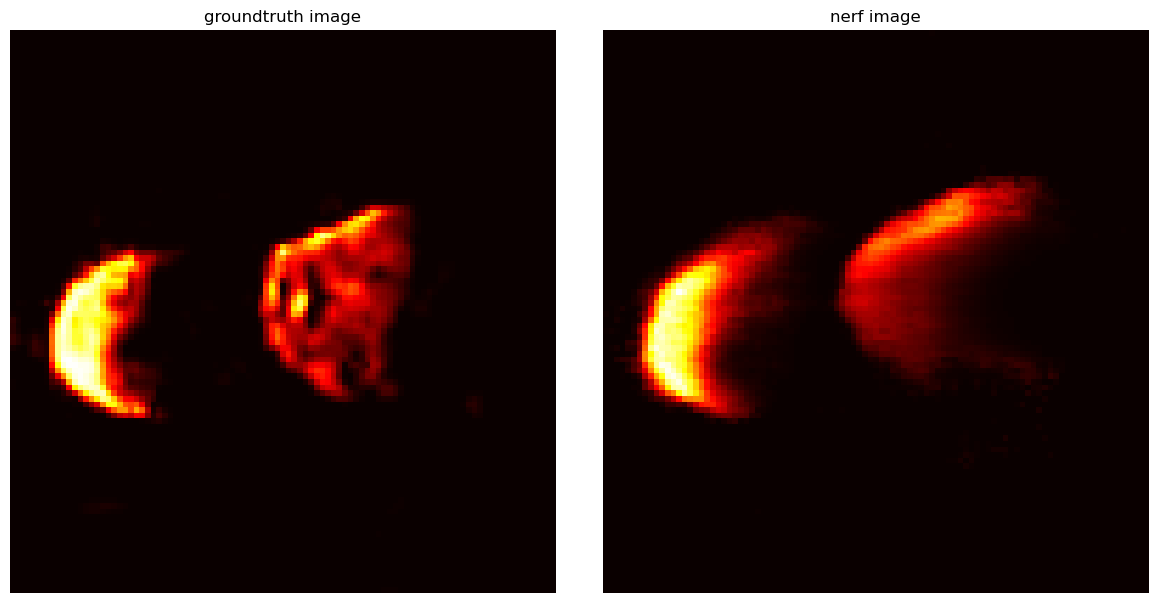

In [ ]:
# 变换位置编码后的验证程序
import torch
import numpy as np
# torch.autograd.set_detect_anomaly(True)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import os
import random
import matplotlib.pyplot as plt
import re

class NeRF(nn.Module):
    def __init__(self, D=8, W=256, input_ch=3, input_ch_views=3, output_ch=2, skips=[4], use_viewdirs=True):
        """
        D: 深度，多少层网络
        W: 网络内的channel 宽度
        input_ch: xyz的宽度
        input_ch_views: direction的宽度
        output_ch: 这个参数尽在 use_viewdirs=False的时候会被使用
        skips: 类似resnet的残差连接，表明在第几层进行连接
        use_viewdirs:

        网络输入已经被位置编码后的参数，输入为[64*bs,90]，输出为[64*bs，2]，一位是体积密度，一位是后向散射系数
        """
        super(NeRF, self).__init__()
        self.D = D
        self.W = W
        self.input_ch = input_ch
        self.input_ch_views = input_ch_views
        self.skips = skips
        self.use_viewdirs = use_viewdirs

        # 神经网络,MLP
        # 3D的空间坐标进入的网络
        # 这个跳跃连接层是直接拼接，不是resnet的那种相加
        self.pts_linears = nn.ModuleList(
            [nn.Linear(input_ch, W)] + [nn.Linear(W, W) if i not in self.skips else nn.Linear(W + input_ch, W) for i in
                                        range(D - 1)])

        # 这里channel削减一半 128
        ### Implementation according to the official code release (https://github.com/bmild/nerf/blob/master/run_nerf_helpers.py#L104-L105)
        self.views_linears = nn.ModuleList([nn.Linear(input_ch_views + W, W // 2)])
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        if use_viewdirs:
            # 特征
            self.feature_linear = nn.Linear(W, W)
            # 体积密度,一个值
            self.alpha_linear = nn.Linear(W, 1)
            # 后向散射系数，一个值
            self.rho_linear = nn.Linear(W // 2, 1)
        else:
            self.output_linear = nn.Linear(W, output_ch)

    def forward(self, x):
        # x [bs*64, 90]
        # input_pts [bs*64, 63]
        # input_views [bs*64,27]
        input_pts, input_views = torch.split(x, [self.input_ch, self.input_ch_views], dim=-1)

        h = input_pts

        for i, l in enumerate(self.pts_linears):

            h = self.pts_linears[i](h)
            h = F.relu(h)
            # 第四层后相加
            if i in self.skips:
                h = torch.cat([input_pts, h], -1)

        if self.use_viewdirs:
            # alpha只与xyz有关
            alpha = self.alpha_linear(h)
            feature = self.feature_linear(h)
            # rho与xyz和d都有关
            h = torch.cat([feature, input_views], -1)

            for i, l in enumerate(self.views_linears):
                h = self.views_linears[i](h)
                h = F.relu(h)

            sigma = self.rho_linear(h)
            alpha = self.relu(alpha) 
            sigma = self.sigmoid(sigma)
            outputs = torch.cat([alpha, sigma], -1)
        else:
            outputs = self.output_linear(h)

        return outputs


def batchrender(omega,LOS,model,doppler_num):
    '''
    omega为一个[bs,3]变量，指向旋转轴方向，模值为角速度
    LOS为一个[bs,3]变量，方向为视线方向指向物体，模值为1
    model是nerf模型，将一个已经进行位置编码后的位置和视线向量输入进model,可以返回这个位置的体积密度和散射系数
    doppler_num为一个[bs]变量，确定了渲染后光线所在的位置
    '''
    # 确定回波波长
    fc = torch.tensor([9.7e9]).to(device)
    c = torch.tensor([299792458]).to(device)
    lambda0 = c/fc
    # 确定网格参数
    distance_max = 0.6
    distance_min = -0.6
    distance_gap = 97
    doppler_max = 0.15
    doppler_min = -0.15
    doppler_gap = 105
    n_max = 0.3
    n_min = -0.3
    n_gap = 120
    # 确定输入batch_size
    batch_size,len = omega.shape
    # 确定每个batch_size输入的投影平面
    omega_norm = torch.linalg.norm(omega,dim = 1)
    omega_normlize = omega/omega_norm.unsqueeze(1)
    Doppler_vector = torch.cross(LOS,omega,dim=1)
    LOSomega_sin_angel = torch.linalg.norm(Doppler_vector,dim=1)/(torch.linalg.norm(omega,dim=1)*torch.linalg.norm(LOS,dim=1))
    Doppler_vector = Doppler_vector/torch.linalg.norm(Doppler_vector,dim = 1).unsqueeze(1)
    # 绘制投影坐标
    distance = torch.linspace(distance_min,distance_max,distance_gap).to(device)
    distance = distance.repeat(batch_size,1)
    distance_delta = torch.tensor((distance_max-distance_min)/distance_gap).to(device)
    doppler = torch.linspace(doppler_min,doppler_max,doppler_gap).repeat(batch_size,1).to(device)
    doppler = doppler*4/LOSomega_sin_angel.unsqueeze(1)
    distance_map = distance.unsqueeze(2)*LOS.unsqueeze(1)
    doppler_map = doppler.unsqueeze(2)*Doppler_vector.unsqueeze(1)
    # 确定投影平面法向量
    n = torch.cross(LOS,Doppler_vector,dim=1)
    n = n/torch.linalg.norm(n,dim = 1).unsqueeze(1)
    # 对投影平面法向量进行随机采样
    n_array = torch.linspace(n_min,n_max,n_gap+1).to(device)
    n_array = n_array.repeat(batch_size,distance_gap,1)
    # 非随机采样
    # n_random_array = n_array[:,:,0:-1] + (n_array[:,:,1:] - n_array[:,:,0:-1])*torch.ones(batch_size,distance_gap,n_gap).to(device)*0.5
    # # 随机采样
    n_random_array = n_array[:,:,0:-1] + (n_array[:,:,1:] - n_array[:,:,0:-1])*torch.rand(batch_size,distance_gap,n_gap).to(device)
    n_random_map = n_random_array.unsqueeze(3)*n.unsqueeze(1).unsqueeze(2)
    # 计算不同随机法向量之间的间隔
    start_n = n.unsqueeze(1).unsqueeze(2)*torch.tensor(n_min).float().to(device)
    start_n = start_n * torch.ones(batch_size,distance_gap,1,3).to(device)
    n_random_map_temp = torch.cat((start_n,n_random_map),dim=2)
    n_delta = torch.norm(n_random_map_temp[:,:,0:-1,:]-n_random_map,dim=3)

    # 计算所有需要输入网络的坐标
    code_flag = 1
    if code_flag == 1:
        xyz = doppler_map[torch.arange(batch_size),doppler_num,:].unsqueeze(1).unsqueeze(2) + distance_map.unsqueeze(2) + n_random_map
        xyz_coding = positon_code_xyz(xyz)
        LOS_coding = position_code_LOS(LOS)
        LOS_coding = ((LOS_coding.unsqueeze(1).unsqueeze(2))*torch.ones(batch_size,distance_gap,n_gap,27).to(device)).view(-1,27)
        xyzLOS_coding = torch.cat((xyz_coding,LOS_coding),dim=1)
    else:
        xyz = doppler_map[torch.arange(batch_size),doppler_num,:].unsqueeze(1).unsqueeze(2) + distance_map.unsqueeze(2) + n_random_map
        xyz_coding = xyz.view(-1,3)
        LOS_coding = ((LOS.unsqueeze(1).unsqueeze(2))*torch.ones(batch_size,distance_gap,n_gap,3).to(device)).view(-1,3)
        print(LOS_coding)
        xyzLOS_coding = torch.cat((xyz_coding,LOS_coding),dim=1)
    output = model(xyzLOS_coding)
    output = output.view(batch_size,distance_gap,n_gap,2)
    render_equaltion = 0
    if render_equaltion == 1:
        Ti = torch.cumprod(torch.exp(-output[:,:,:,0]*distance_delta),dim=1)
        distance_profile = torch.sum(output[:,:,:,0]*(1-torch.exp(-output[:,:,:,1]*n_delta))*Ti,dim=2)
    else:
        Ti = torch.cumprod(torch.exp(-output[:,:,:,0]**2*distance_delta),dim=1)
        distance_profile = torch.sum(output[:,:,:,0]*output[:,:,:,1]*n_delta*Ti,dim=2)

    return distance_profile

def positon_code_xyz(xyz):
    code_len = 10
    batch_size,distance,n,dimension = xyz.shape
    xyz = xyz.view(-1,dimension)
    xyz = xyz
    position_coding = torch.zeros_like(xyz).to(device)
    position_coding = position_coding.repeat(1,code_len*2)
    div_term = 2 ** torch.arange(0,code_len,step=1).to(device)
    position_coding[:,0::2] = torch.sin((xyz.unsqueeze(1) * math.pi * div_term.unsqueeze(1).unsqueeze(0)).view(batch_size*distance*n,-1))
    position_coding[:,1::2] = torch.cos((xyz.unsqueeze(1) * math.pi * div_term.unsqueeze(1).unsqueeze(0)).view(batch_size*distance*n,-1))
    position_coding = torch.cat((xyz,position_coding),dim=1)
    
    return position_coding

def position_code_LOS(LOS):
    code_len = 4
    batch_size,dimension = LOS.shape
    position_coding = torch.zeros_like(LOS).to(device)
    position_coding = position_coding.repeat(1,code_len*2)
    div_term = 2 ** torch.arange(0,code_len,step=1).to(device)
    position_coding[:,0::2] = torch.sin((LOS.unsqueeze(1) * math.pi * div_term.unsqueeze(1).unsqueeze(0)).view(batch_size,-1))
    position_coding[:,1::2] = torch.cos((LOS.unsqueeze(1) * math.pi * div_term.unsqueeze(1).unsqueeze(0)).view(batch_size,-1))
    position_coding = torch.cat((LOS,position_coding),dim=1)

    return position_coding

def picture_sample(images,LOS_dirs,omegas,batch_size,image_hight = 105,image_width = 79, image_num = 37):
    temp_num = random.sample(range(image_num),1)
    temp_num = [1]
    print(temp_num)
    temp = [t*image_hight for t in temp_num] + np.arange(100)
    data_num = [x//image_hight for x in temp]
    doppler_numbers = [x % image_hight for x in temp]
    
    LOS_dirs_batch = [LOS_dirs[x] for x in data_num]
    omegas_batch = [omegas[x] for x in data_num]
    range_profile_batch = [images[x][y,:] for x,y in zip(data_num,doppler_numbers)]

    omegas_batch_tensor = torch.stack(omegas_batch).to(device)
    LOS_dirs_batch_tensor = torch.stack(LOS_dirs_batch).to(device)
    range_profile_batch_tensor = torch.stack(range_profile_batch).to(device)
    doppler_profil_num_tensor = torch.tensor(doppler_numbers).long().to(device)

    # range_image = range_profile_batch_tensor.detach().cpu()
    # plt.imshow(range_image)
    # plt.show()
    
    return omegas_batch_tensor,LOS_dirs_batch_tensor,range_profile_batch_tensor,doppler_profil_num_tensor

def natural_sort_key(s):
    # 分割字符串中的数字并将它们转换为整数
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def loaddata(folder_path):
    '''
    输入文件夹路径，输出数据集
    '''
    # 获取文件夹中的所有文件和子文件夹
    items = os.listdir(folder_path)
    # 过滤出所有文件（排除子文件夹）
    files = [item for item in items if os.path.isfile(os.path.join(folder_path, item)) and item.endswith('.npz')]
    files_sorted = sorted(files, key=natural_sort_key)
    #载入数据
    images = []
    LOS_dirs = []
    omegas = []
    for file in files_sorted:
        full_path = folder_path+"/"+file
        data = np.load(full_path)
        image = torch.from_numpy(data['image']).to(device)
        LOS_dir = torch.from_numpy(data['LOS']).to(device)
        omega = torch.from_numpy(data['rotation_axis']).to(device)
        images.append(image)
        LOS_dirs.append(LOS_dir)
        omegas.append(omega)
    return images,LOS_dirs,omegas

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

model = NeRF(input_ch = 63, input_ch_views = 27, use_viewdirs = True).to(device)
model.load_state_dict(torch.load('/DATA/disk1/ISAR_NERF/model_state_dict99.pth'))
model.eval()

omega_real = math.pi/900

folder_path = '/DATA/disk1/3dmodel/3dmodel/ISAR_NERF/asteroid_image_nerf_new/real_data_reg_2024On_2'
images,LOS_dirs,omegas = loaddata(folder_path)

omegas_batch_tensor,LOS_dirs_batch_tensor,range_profile_batch_tensor,doppler_profil_num_tensor = picture_sample(images,LOS_dirs,omegas,batch_size = 40)
distance_profile_batch = batchrender(omegas_batch_tensor*omega_real,LOS_dirs_batch_tensor,model,doppler_profil_num_tensor)

# print(LOS_dirs)
# print(LOS_dirs_batch_tensor)

range_image1 = distance_profile_batch.detach().cpu()
# plt.figure()
# plt.imshow(range_image1)
# plt.colorbar()


range_image2 = range_profile_batch_tensor.detach().cpu()
# plt.figure()
# plt.imshow(range_image2)
# plt.colorbar()
# plt.show()
# 创建子图
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 图像1
axes[0].imshow(range_image2,cmap='hot')
axes[0].set_title("groundtruth image")
axes[0].axis('off')

# 图像2
axes[1].imshow(range_image1,cmap='hot')
axes[1].set_title("nerf image")
axes[1].axis('off')

# 将图像保存为temp_num.png
plt.savefig('temp_num.png')

# 计算图像之间的MSE
mse = ((range_image1 - range_image2) ** 2).mean()
print(mse)
plt.tight_layout()
plt.show()
